### Evaluating the MSTI data after re-pipelining

- Prepared by: Grace Patlewicz
- Last modified: 24 January 2023 following journal peer review
- Changes: 
- Re-calculating odds ratio and Fisher exact test since wrong hypothesis test was chosen in the code. Should have been greater than rather than the default of a 2-sided test
- Use of a correction factor to adjust the significance levels of the Fisher exact test - Bonferroni, Sidak, Holm, FDR corrections considered and evaluated.

- Notebook captures the evaluation of the MSTI data, its hit rate, use of the max as an aggregation strategy, enrichment assessment of the TxPs and comparison to previous work reported in Nelms et al (2019).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
import openpyxl

In [3]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP + 'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


#### Reading in the sc2 msti  data

In [4]:
xls = pd.read_excel(processed_dir+'MSTI_invitrodb_01Nov2021_GP.xlsx', sheet_name = None)

In [5]:
xls.keys()

dict_keys(['comparison_of_all', 'sc2', 'sc1', 'sc0', 'simmons_pilot', 'aeid_table'])

In [6]:
sc2 = pd.read_excel(processed_dir+'MSTI_invitrodb_01Nov2021_GP.xlsx', sheet_name = 'sc2')

In [7]:
sc2.shape

(19339, 15)

In [8]:
sc2.head()

,spid,chid,casn,chnm,dsstox_substance_id,code,aeid,aenm,s2id,bmad,max_med,hitc,coff,resp_unit,conc_unit
0,DMSO,NaN,67-68-5,Dimethyl sulfoxide,DTXSID2021735,NaN,2543,TOX21_msti_p2_activity,5005221,4.641546,0.000000,0,13.924638,percent_activity,NaN
1,DMSO,NaN,67-68-5,Dimethyl sulfoxide,DTXSID2021735,NaN,3017,TOX21_msti_p3_activity,5024176,6.962048,0.000000,0,20.886145,percent_activity,NaN
2,MLS,NaN,374091-47-1,"(E)-3-(3,5-Dibromo-2-hydroxyphenyl)-1-(5-methy...",MLS,NaN,2543,TOX21_msti_p2_activity,5005222,4.641546,100.229026,1,13.924638,percent_activity,NaN
3,MLS,NaN,374091-47-1,"(E)-3-(3,5-Dibromo-2-hydroxyphenyl)-1-(5-methy...",MLS,NaN,3017,TOX21_msti_p3_activity,5024175,6.962048,103.864036,1,20.886145,percent_activity,NaN
4,Tox21_110005_1,45081.0,2439-07-8,8-Quinolinol salicylic acid (1:1),DTXSID1045081,C2439078,2543,TOX21_msti_p2_activity,5005859,4.641546,1.058936,0,13.924638,percent_activity,uM


In [9]:
sc2[sc2['spid'] == 'DMSO']

,spid,chid,casn,chnm,dsstox_substance_id,code,aeid,aenm,s2id,bmad,max_med,hitc,coff,resp_unit,conc_unit
0,DMSO,NaN,67-68-5,Dimethyl sulfoxide,DTXSID2021735,NaN,2543,TOX21_msti_p2_activity,5005221,4.641546,0.0,0,13.924638,percent_activity,NaN
1,DMSO,NaN,67-68-5,Dimethyl sulfoxide,DTXSID2021735,NaN,3017,TOX21_msti_p3_activity,5024176,6.962048,0.0,0,20.886145,percent_activity,NaN


In [10]:
sc2[sc2['spid'] == 'MLS']

,spid,chid,casn,chnm,dsstox_substance_id,code,aeid,aenm,s2id,bmad,max_med,hitc,coff,resp_unit,conc_unit
2,MLS,NaN,374091-47-1,"(E)-3-(3,5-Dibromo-2-hydroxyphenyl)-1-(5-methy...",MLS,NaN,2543,TOX21_msti_p2_activity,5005222,4.641546,100.229026,1,13.924638,percent_activity,NaN
3,MLS,NaN,374091-47-1,"(E)-3-(3,5-Dibromo-2-hydroxyphenyl)-1-(5-methy...",MLS,NaN,3017,TOX21_msti_p3_activity,5024175,6.962048,103.864036,1,20.886145,percent_activity,NaN


In [11]:
sc2_p2 = sc2[sc2['aenm'] == 'TOX21_msti_p2_activity']

In [12]:
sc2_p2.shape

(9670, 15)

In [13]:
sc2_p2[sc2_p2['spid'] == 'MLS']

,spid,chid,casn,chnm,dsstox_substance_id,code,aeid,aenm,s2id,bmad,max_med,hitc,coff,resp_unit,conc_unit
2,MLS,NaN,374091-47-1,"(E)-3-(3,5-Dibromo-2-hydroxyphenyl)-1-(5-methy...",MLS,NaN,2543,TOX21_msti_p2_activity,5005222,4.641546,100.229026,1,13.924638,percent_activity,NaN


In [14]:
sc2_p2[sc2_p2['spid'] == 'DMSO']

,spid,chid,casn,chnm,dsstox_substance_id,code,aeid,aenm,s2id,bmad,max_med,hitc,coff,resp_unit,conc_unit
0,DMSO,NaN,67-68-5,Dimethyl sulfoxide,DTXSID2021735,NaN,2543,TOX21_msti_p2_activity,5005221,4.641546,0.0,0,13.924638,percent_activity,NaN


In [15]:
sc2_p2.dsstox_substance_id.nunique()

7872

In [16]:
sc2_p2.loc[19338, 'spid'] = 'null'

In [17]:
sc2_p2.tail()

,spid,chid,casn,chnm,dsstox_substance_id,code,aeid,aenm,s2id,bmad,max_med,hitc,coff,resp_unit,conc_unit
19330,Tox21_400085,24109.0,66332-96-5,Flutolanil,DTXSID8024109,C66332965,2543,TOX21_msti_p2_activity,5004959,4.641546,-48.163479,0,13.924638,percent_activity,uM
19332,Tox21_400086,21166.0,51-03-6,Piperonyl butoxide,DTXSID1021166,C51036,2543,TOX21_msti_p2_activity,5004891,4.641546,18.428855,1,13.924638,percent_activity,uM
19334,Tox21_400087,32520.0,131860-33-8,Azoxystrobin,DTXSID0032520,C131860338,2543,TOX21_msti_p2_activity,5005107,4.641546,15.401506,1,13.924638,percent_activity,uM
19336,Tox21_400088,20182.0,80-05-7,Bisphenol A,DTXSID7020182,C80057,2543,TOX21_msti_p2_activity,5005723,4.641546,-69.040847,0,13.924638,percent_activity,uM
19338,null,NaN,NaN,NaN,NaN,NaN,2543,TOX21_msti_p2_activity,5007423,4.641546,-0.970358,0,13.924638,percent_activity,NaN


#### What does the hitcall look like for the msti data p2

In [18]:
sc2_p2.hitc.value_counts(normalize = True)

0    0.722027
1    0.277973
Name: hitc, dtype: float64

In [19]:
sc2_p2.hitc.value_counts()

0    6982
1    2688
Name: hitc, dtype: int64

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

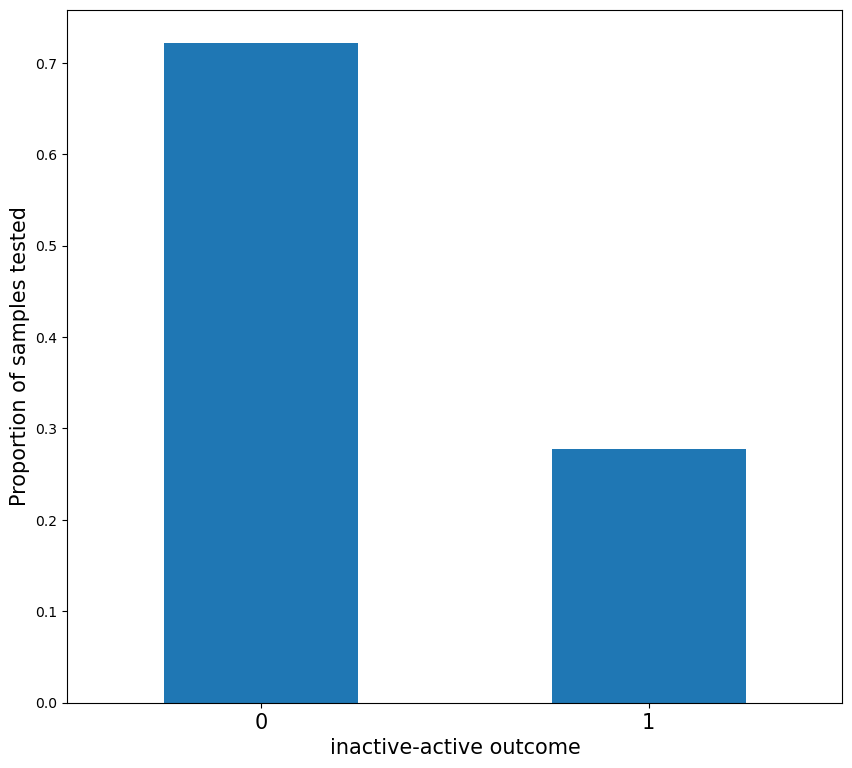

In [20]:
sc2_p2.hitc.value_counts(normalize = True).plot.bar(figsize = (10,9))
plt.ylabel('Proportion of samples tested', fontsize = 15)
plt.xlabel('inactive-active outcome', fontsize = 15)
plt.xticks(rotation = 360, fontsize = 15)
#plt.savefig(figures_dir+'p2_hitcall_value_counts_190822.png', dpi = 300);

#### Checking the number of unique samples vs dtxsid reveals that there are some substances tested more than once. 

In [21]:
sc2_p2.spid.nunique()

9670

In [22]:
sc2_p2.dsstox_substance_id.nunique()

7872

In [23]:
sc2_p2[sc2_p2['dsstox_substance_id'] == 'DTXSID7020348']

,spid,chid,casn,chnm,dsstox_substance_id,code,aeid,aenm,s2id,bmad,max_med,hitc,coff,resp_unit,conc_unit
1672,Tox21_111141_1,20348.0,91-64-5,Coumarin,DTXSID7020348,C91645,2543,TOX21_msti_p2_activity,5006356,4.641546,-8.189789,0,13.924638,percent_activity,uM
9784,Tox21_202427,20348.0,91-64-5,Coumarin,DTXSID7020348,C91645,2543,TOX21_msti_p2_activity,5012245,4.641546,-0.850443,0,13.924638,percent_activity,uM
11288,Tox21_300057,20348.0,91-64-5,Coumarin,DTXSID7020348,C91645,2543,TOX21_msti_p2_activity,5011403,4.641546,0.708777,0,13.924638,percent_activity,uM


#### Exploring what substances were tested in duplicate or triplicate

In [24]:
test = sc2_p2.groupby(['dsstox_substance_id']).agg({'dsstox_substance_id' : 'count'}).rename(columns = {'dsstox_substance_id': 'count'}).reset_index()

In [25]:
test[test['count'] ==3]

,dsstox_substance_id,count
9,DTXSID0020107,3
33,DTXSID0020446,3
42,DTXSID0020577,3
47,DTXSID0020652,3
51,DTXSID0020737,3
...,...,...
7386,DTXSID9027312,3
7391,DTXSID9027441,3
7395,DTXSID9027522,3
7442,DTXSID9033187,3


In [26]:
test[test['count'] ==2]

,dsstox_substance_id,count
0,DTXSID0020020,2
1,DTXSID0020022,2
6,DTXSID0020076,2
10,DTXSID0020151,2
14,DTXSID0020232,2
...,...,...
7601,DTXSID9045007,2
7664,DTXSID9046445,2
7699,DTXSID9047174,2
7718,DTXSID9047461,2


##### Filtering the dataset to look at the substances tested more than once in order to explote a bootstrapping approach

In [27]:


deps = sc2_p2.groupby(['dsstox_substance_id']).filter(lambda x: len(x) > 1)

In [28]:
deps.dsstox_substance_id.value_counts()

DTXSID1021118    3
DTXSID1020144    3
DTXSID7020348    3
DTXSID6020721    3
DTXSID2021238    3
                ..
DTXSID1020512    2
DTXSID0022014    2
DTXSID2025133    2
DTXSID4021971    2
DTXSID0024000    2
Name: dsstox_substance_id, Length: 1582, dtype: int64

In [29]:
deps.dsstox_substance_id.nunique()

1582

In [30]:
deps

,spid,chid,casn,chnm,dsstox_substance_id,code,aeid,aenm,s2id,bmad,max_med,hitc,coff,resp_unit,conc_unit
0,DMSO,NaN,67-68-5,Dimethyl sulfoxide,DTXSID2021735,NaN,2543,TOX21_msti_p2_activity,5005221,4.641546,0.000000,0,13.924638,percent_activity,NaN
6,Tox21_110008_1,25513.0,2437-29-8,Malachite green oxalate,DTXSID6025513,C2437298,2543,TOX21_msti_p2_activity,5006503,4.641546,96.618183,1,13.924638,percent_activity,uM
8,Tox21_110010_1,26727.0,106-24-1,"(2E)-3,7-Dimethyl-2,6-octadien-1-ol",DTXSID8026727,C106241,2543,TOX21_msti_p2_activity,5005314,4.641546,-7.847827,0,13.924638,percent_activity,uM
10,Tox21_110012_1,22408.0,143-74-8,Phenol red,DTXSID8022408,C143748,2543,TOX21_msti_p2_activity,5005162,4.641546,55.793625,1,13.924638,percent_activity,uM
28,Tox21_110027_1,42424.0,59-40-5,Sulfaquinoxaline,DTXSID8042424,C59405,2543,TOX21_msti_p2_activity,5005334,4.641546,14.339215,1,13.924638,percent_activity,uM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19302,Tox21_400071,24000.0,1861-32-1,Chlorthal-dimethyl,DTXSID0024000,C1861321,2543,TOX21_msti_p2_activity,5005249,4.641546,-1.637525,0,13.924638,percent_activity,uM
19304,Tox21_400072,21322.0,97-77-8,Tetraethylthiuram disulfide,DTXSID1021322,C97778,2543,TOX21_msti_p2_activity,5005275,4.641546,38.997221,1,13.924638,percent_activity,uM
19318,Tox21_400079,32498.0,3380-34-5,Triclosan,DTXSID5032498,C3380345,2543,TOX21_msti_p2_activity,5005089,4.641546,9.564509,0,13.924638,percent_activity,uM
19332,Tox21_400086,21166.0,51-03-6,Piperonyl butoxide,DTXSID1021166,C51036,2543,TOX21_msti_p2_activity,5004891,4.641546,18.428855,1,13.924638,percent_activity,uM


#### Let's just look at the variation in hitcall outcome for these cases to see what the best strategy might be to aggregate the hitcall values

In [31]:
a_calls = {}
for i, group in deps.groupby(['dsstox_substance_id']):
    key = [n for n in group['dsstox_substance_id'] if n !=' '][0]
    value = list(group['hitc'])
    a_calls[key] =value

In [32]:
len(a_calls)

1582

#### Reproducibility of the MSTI outcomes for replicate values

In [33]:
n_bootstraps = 500
SubsetforBootstrap = pd.DataFrame(index=[], \
                                      columns=['dsstox_substance_id','OutcomeArray', '%Pos', '%Neg','Unalikeability',\
                                               'BootstrappedArray', '%bPos', '%bNeg','BUnalikeability'])
idx = 0
for dtxsid, group in deps.groupby('dsstox_substance_id'):
    #cas = group['casrn'].unique()
    OutcomeArray = np.array(group['hitc'])
    
    
    # create a bootstraped value array
    Bootstrapvalues = np.array(np.random.choice(OutcomeArray, replace=True, size=n_bootstraps))
        
    # Calculate the % of 0,1  in original data
    PercPos = 100*(OutcomeArray==1).sum()/len(OutcomeArray)
    PercNeg = 100*(OutcomeArray==0).sum()/len(OutcomeArray)
    unalikeability = 2*PercPos*PercNeg/10000 #keep it as a number between 0 and 1
    #PercInc = 100*(AmesOutcomeArraynoInc==2).sum()/len(AmesOutcomeArraynoInc)
        
     # Calculate the % of 0,1 in bootsstrapped data
    BPercPos = 100*(Bootstrapvalues==1).sum()/n_bootstraps
    BPercNeg = 100*(Bootstrapvalues==0).sum()/n_bootstraps
    Bunalikeability = 2*BPercPos*BPercNeg/10000 #keep it as a number between 0 and 1
    #bPercInc = 100*(bootstrapvalues==2).sum()/n_bootstraps
       
        
    # Update the DataFrame
    SubsetforBootstrap.loc[idx,'dsstox_substance_id'] = dtxsid
       
    SubsetforBootstrap.loc[idx, 'OutcomeArray'] = OutcomeArray
    SubsetforBootstrap.loc[idx, '%Pos']= PercPos
    SubsetforBootstrap.loc[idx, '%Neg'] = PercNeg
    SubsetforBootstrap.loc[idx, 'Unalikeability'] = unalikeability
    SubsetforBootstrap.loc[idx, 'BootstrappedArray'] = Bootstrapvalues
    SubsetforBootstrap.loc[idx, '%bPos']= BPercPos
    SubsetforBootstrap.loc[idx, '%bNeg'] = BPercNeg    
    SubsetforBootstrap.loc[idx, 'BUnalikeability'] = float(Bunalikeability)
        
        # Update the index
    idx=idx+1

SubsetforBootstrap.index = SubsetforBootstrap['dsstox_substance_id']

In [34]:
SubsetforBootstrap[SubsetforBootstrap['BUnalikeability'] != 0]

,dsstox_substance_id,OutcomeArray,%Pos,%Neg,Unalikeability,BootstrappedArray,%bPos,%bNeg,BUnalikeability
dsstox_substance_id,,,,,,,,,
DTXSID0020107,DTXSID0020107,"[1, 0, 1]",66.666667,33.333333,0.444444,"[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, ...",66.2,33.8,0.447512
DTXSID0020236,DTXSID0020236,"[1, 0]",50.0,50.0,0.5,"[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, ...",52.6,47.4,0.498648
DTXSID0020286,DTXSID0020286,"[0, 1]",50.0,50.0,0.5,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...",49.0,51.0,0.4998
DTXSID0020369,DTXSID0020369,"[0, 1]",50.0,50.0,0.5,"[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...",48.8,51.2,0.499712
DTXSID0020606,DTXSID0020606,"[1, 0]",50.0,50.0,0.5,"[0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, ...",52.4,47.6,0.498848
...,...,...,...,...,...,...,...,...,...
DTXSID9029649,DTXSID9029649,"[1, 0]",50.0,50.0,0.5,"[1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...",53.0,47.0,0.4982
DTXSID9040683,DTXSID9040683,"[0, 1]",50.0,50.0,0.5,"[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, ...",52.6,47.4,0.498648
DTXSID9044112,DTXSID9044112,"[0, 1]",50.0,50.0,0.5,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, ...",47.4,52.6,0.498648


In [35]:
SubsetforBootstrap['Unalikeability'].value_counts(normalize = True)

0.000000    0.857775
0.500000    0.113780
0.444444    0.028445
Name: Unalikeability, dtype: float64

In [36]:
SubsetforBootstrap['Unalikeability'].value_counts(normalize = False)

0.000000    1357
0.500000     180
0.444444      45
Name: Unalikeability, dtype: int64

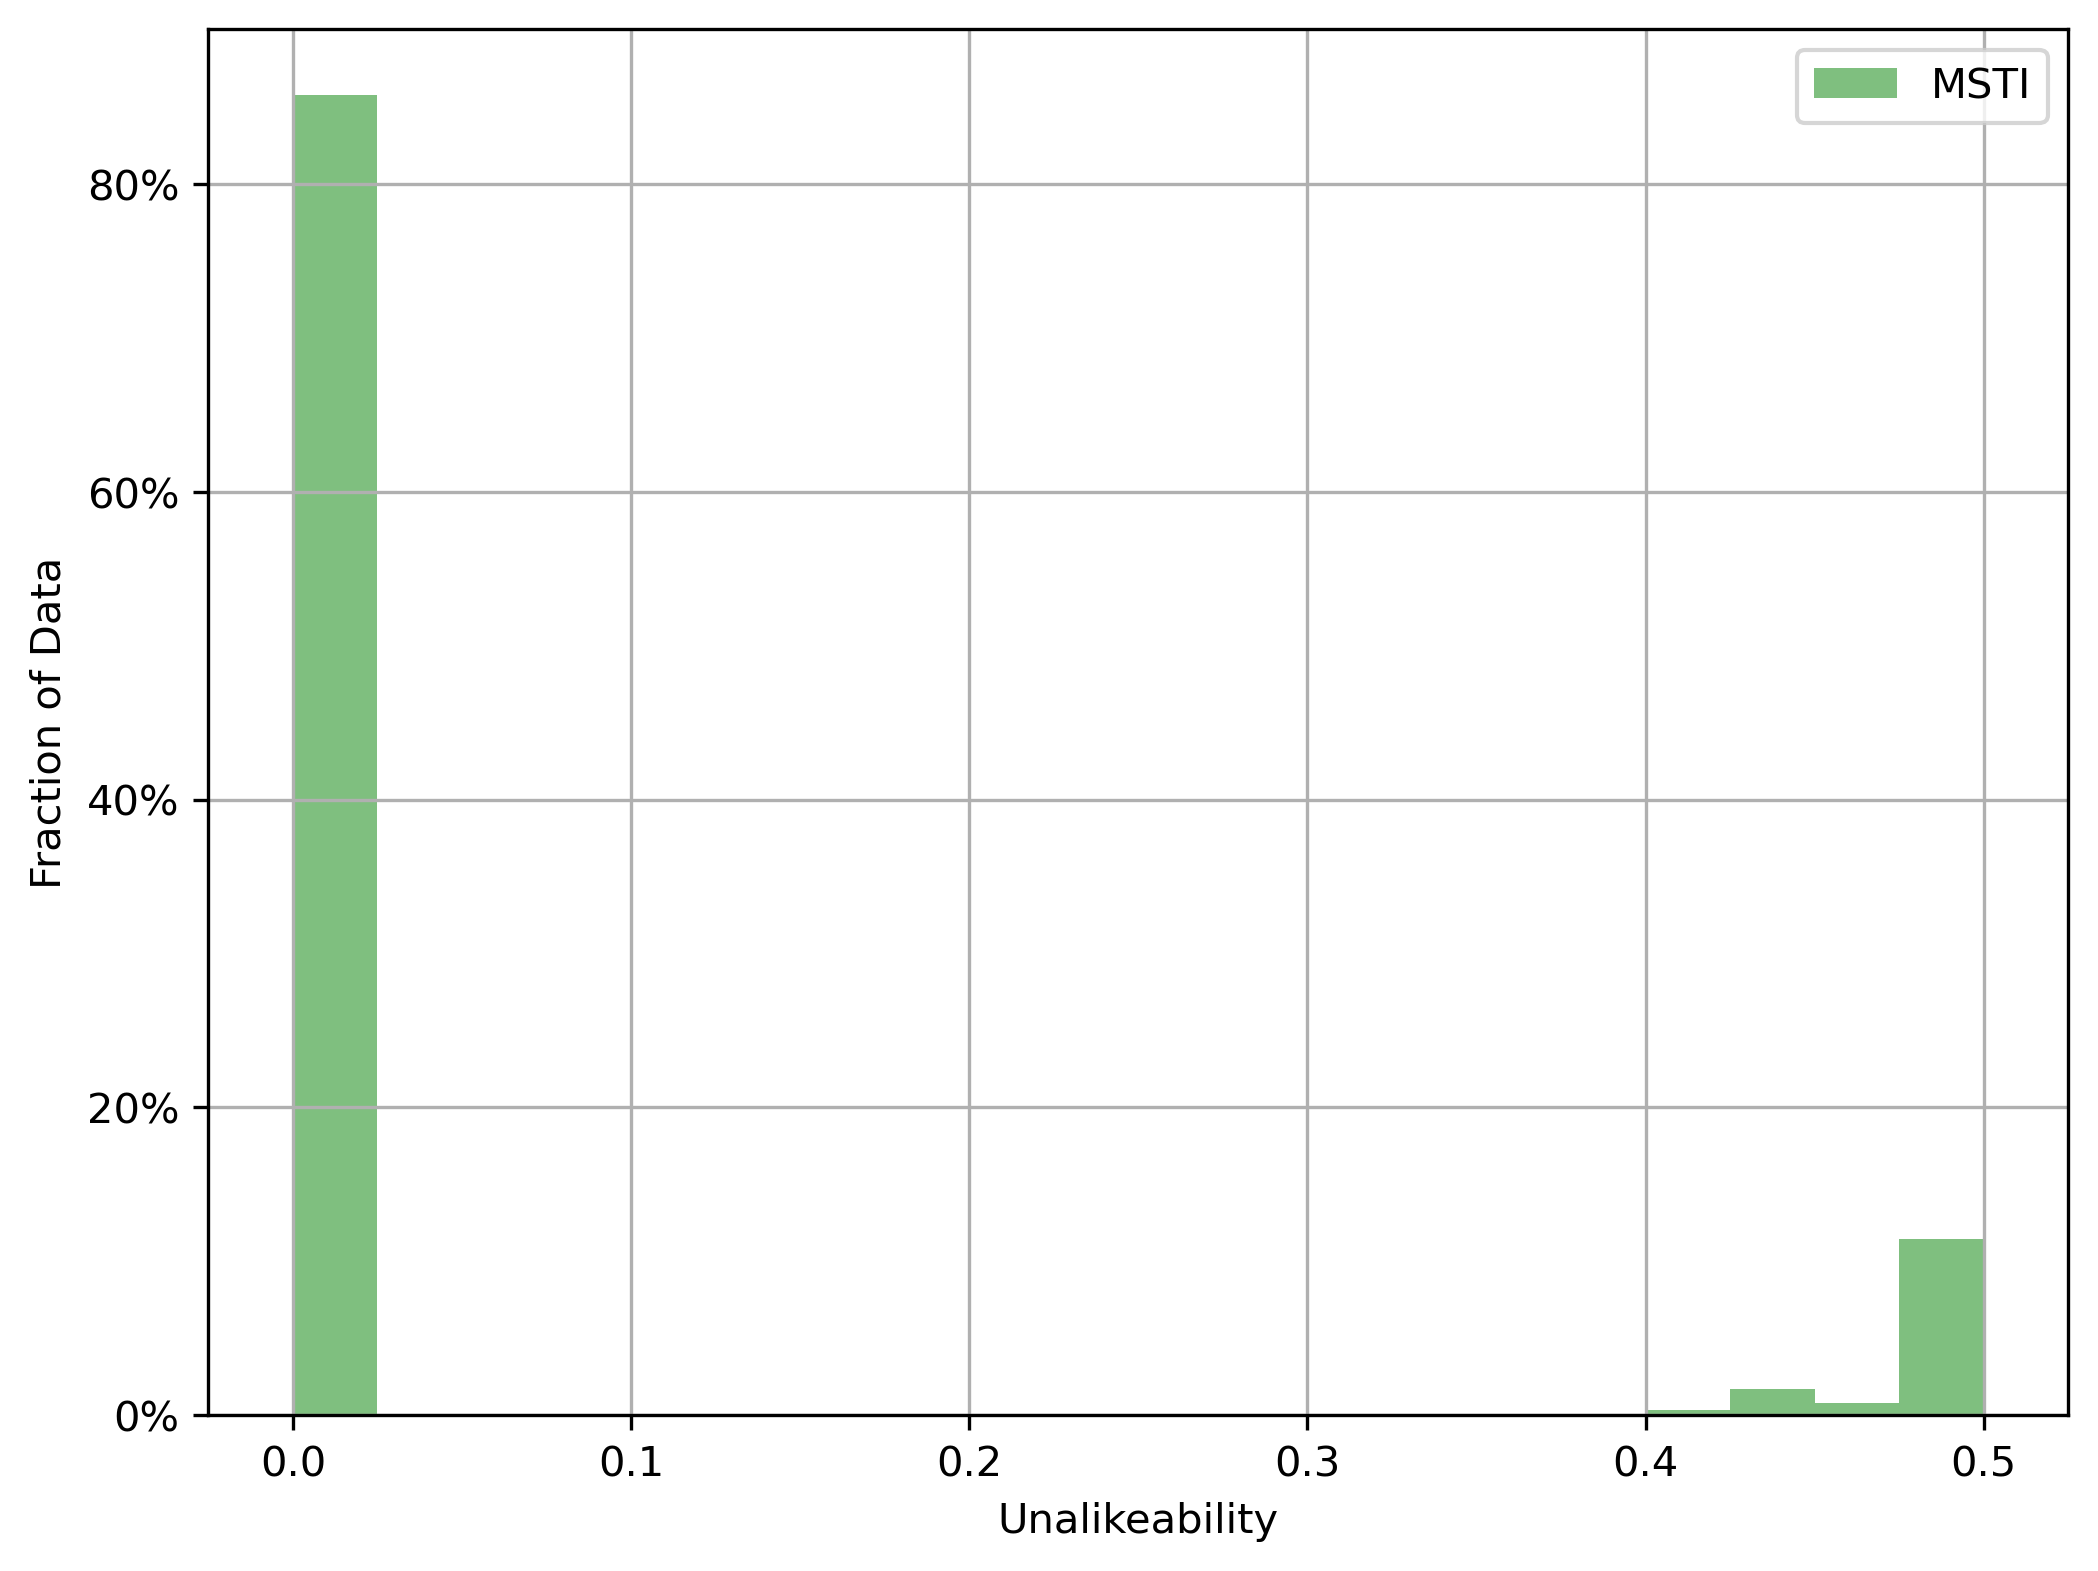

In [37]:
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(8, 6), dpi = 300)
totaldata = len(SubsetforBootstrap['BUnalikeability'].dropna())
SubsetforBootstrap['BUnalikeability'].astype('float64').hist(bins=20,  weights=np.ones(totaldata)/(totaldata), color='g', alpha=0.5, label='MSTI')


plt.legend()
plt.xlabel('Unalikeability')
plt.ylabel('Fraction of Data')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig(figures_dir+'unalikeability_190822.png', bbox_inches='tight')

Just looking at the boxplots for the variation of hitcall - not particularly informative for the hitcalls

In [38]:
my_dict = dict(list(a_calls.items())[0:200])

Text(0, 0.5, 'hitc')

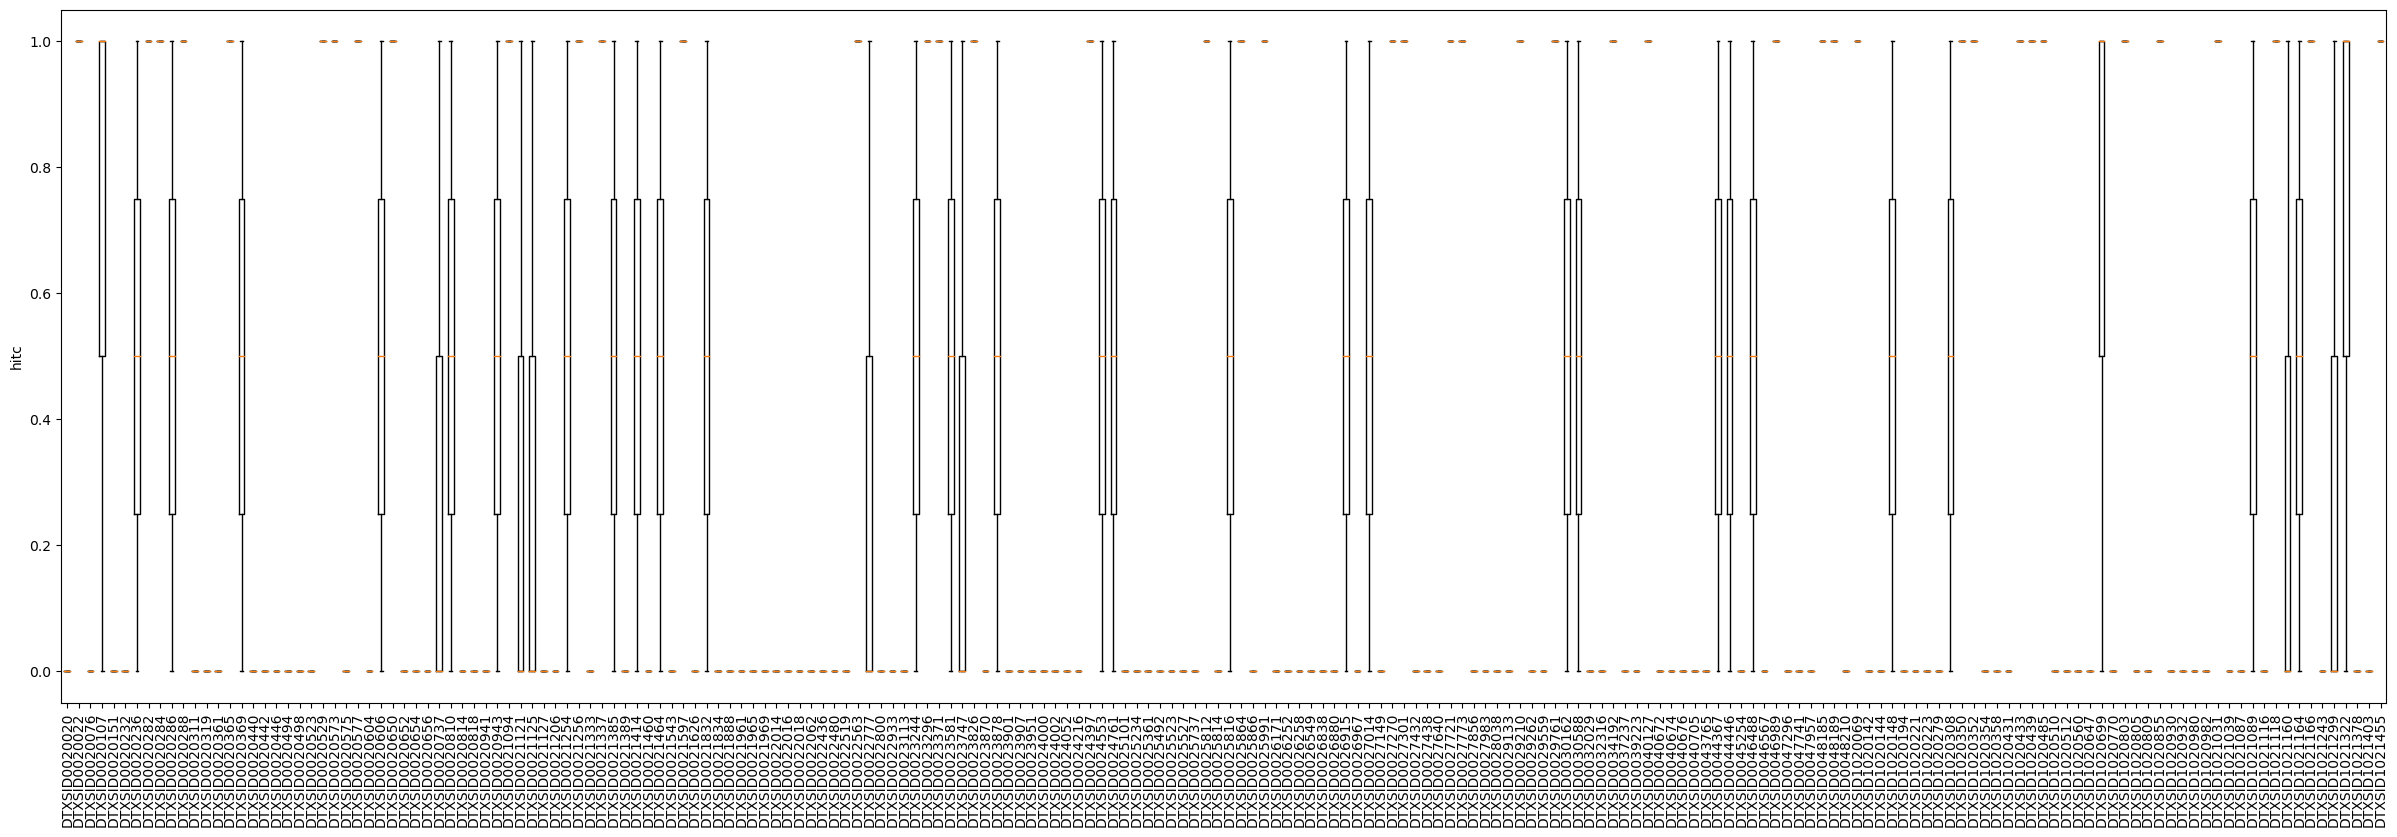

In [39]:
fig, ax = plt.subplots(figsize = (30,9))
labels, data = [*zip(*my_dict.items())]
ax.boxplot(data)
plt.xticks(range(1, len(labels) +1), labels, rotation = 'vertical')
plt.ylabel('hitc')

In [40]:
#a_calls

#### Opting to take the maximum hitcall value - as set a conservative threshold of over 90% agreement to take a majority value

In [41]:
df = sc2_p2.groupby('dsstox_substance_id')['hitc'].max().reset_index().merge(sc2_p2[['dsstox_substance_id','chnm','casn']], on = 'dsstox_substance_id', how = 'left').drop_duplicates(subset = 'dsstox_substance_id', keep = 'first')

In [42]:
df = df[['dsstox_substance_id', 'chnm', 'casn','hitc']]

In [43]:
df.hitc.value_counts(normalize = True)

0    0.710493
1    0.289507
Name: hitc, dtype: float64

In [44]:
df.hitc.value_counts(normalize = False)

0    5593
1    2279
Name: hitc, dtype: int64

In [45]:
df.head()

,dsstox_substance_id,chnm,casn,hitc
0,DTXSID0020020,4-Acetylaminophenylacetic acid,18699-02-0,0
2,DTXSID0020022,Acifluorfen,50594-66-6,1
4,DTXSID0020024,Acrolein diethylacetal,3054-95-3,0
5,DTXSID0020070,Aminocaproic acid,60-32-2,0
6,DTXSID0020072,4-Biphenylamine hydrochloride,2113-61-3,1


In [46]:
df.to_csv(processed_dir+'MSTI_p2_190822.csv')

#### Merging in with ToxPrints to compute enrichments

In [47]:
ids = df.dsstox_substance_id.tolist()

In [48]:
txps = pd.read_csv(raw_dir+'msti_txps_res.txt', sep = '\t')

In [49]:
txps = txps[txps['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']

In [50]:
txps = txps[~txps.duplicated()]

In [51]:
txps_ = txps[txps['M_NAME'].isin(ids)]


In [52]:
txps_.drop(['M_COMPOUND_HISTORY_[STRING]', 'M_CORINA_SYMPHONY_ERRORS_[STRING]'], axis = 1, inplace = True)

In [53]:
txps_.rename(columns = {'M_NAME': 'dsstox_substance_id'}, inplace = True)

In [54]:
df2 = pd.merge(txps_, df, on = 'dsstox_substance_id', how = 'left')

In [55]:
df2.shape

(7532, 733)

In [56]:
df2.set_index('dsstox_substance_id', inplace = True)

In [57]:
df2.to_csv(processed_dir+'TxPs_hitcall_190822.csv')

In [58]:
df[df['dsstox_substance_id'] =='DTXSID1045081']

,dsstox_substance_id,chnm,casn,hitc
1657,DTXSID1045081,8-Quinolinol salicylic acid (1:1),2439-07-8,0


In [59]:
import scipy.stats as stats

In [60]:
res_txp = []
for i, column in df2.iloc[:,0:-3].iteritems():
    if pd.crosstab(df2.iloc[:,-1], column).shape == (2,2):
        a = pd.crosstab(df2.iloc[:,-1], column)
        tn, fp, fn, tp = a.iloc[0,0], a.iloc[0,1], a.iloc[1,0], a.iloc[1,1]
        tested_active = (tp + fn)
        oddsratio, pvalue = stats.fisher_exact(a, alternative = 'greater')
        res_txp.append([oddsratio, pvalue, i, tp, fn, fp, tn, tested_active])

In [61]:
df2.shape

(7532, 732)

In [62]:
def convert(lst):
    df = pd.DataFrame(lst)
    df.rename(columns = {0: 'OR', 1: 'p', 2 : 'TxP', 3: 'TP', 4: 'FN', 5: 'FP', 6: 'TN', 7: 'Tested_Active'}, inplace = True)
    df = df.sort_values(by=['OR','p'], ascending = [False, True])
    return df

In [63]:
txp_msti_enrich = convert(res_txp)

In [64]:
txp_msti_enrich[txp_msti_enrich['TxP'] == 'bond:N=N_azo_aliphatic_acyclic']

,OR,p,TxP,TP,FN,FP,TN,Tested_Active
188,inf,0.007068,bond:N=N_azo_aliphatic_acyclic,4,2181,0,5347,2185


In [65]:
b = pd.crosstab(df2.iloc[:,-1], df2['bond:C(=O)O_carboxylicAcid_alkenyl'])
print(b)
print(b.iloc[0,0], b.iloc[0,1], b.iloc[1,0], b.iloc[1,1])

bond:C(=O)O_carboxylicAcid_alkenyl     0   1
hitc                                        
0                                   5286  61
1                                   2101  84
5286 61 2101 84


#### Criteria for deciding whether a ToxPrint was enriched relied on p level less than 0.05, OR >= 3 and number of TPs >= 3. This is quite stringent except based on reviewer comments, we ought to have adjusted the significance levels for the substances to accomodate FWER for multiple comparisons.

In [66]:
txp_msti_enriched = txp_msti_enrich[(txp_msti_enrich['OR'] >= 3) & (txp_msti_enrich['p'] < 0.05 ) & (txp_msti_enrich['TP'] >=3)]

In [67]:
txp_msti_enriched

,OR,p,TxP,TP,FN,FP,TN,Tested_Active
188,inf,7.068338e-03,bond:N=N_azo_aliphatic_acyclic,4,2181,0,5347,2185
14,inf,2.438933e-02,bond:C(~Z)~C~Q_a-haloketone_perhalo,3,2182,0,5347,2185
17,inf,2.438933e-02,bond:C(~Z)~C~Q_halocarbonyl_dichloro_quinone_(...,3,2182,0,5347,2185
37,inf,2.438933e-02,bond:C(=O)O_carboxylicEster_4-nitrophenol,3,2182,0,5347,2185
201,inf,2.438933e-02,bond:NN_hydrazine_alkyl_H,3,2182,0,5347,2185
...,...,...,...,...,...,...,...,...
33,3.464580,2.265341e-13,bond:C(=O)O_carboxylicAcid_alkenyl,84,2101,61,5286,2185
205,3.426569,6.120596e-05,bond:NN_hydrazine_alkyl_N(connect_Z=1),25,2160,18,5329,2185
511,3.286114,1.372136e-11,ring:hetero_[5]_N_pyrrole,76,2109,58,5289,2185
372,3.011198,4.974883e-04,chain:alkeneCyclic_diene_cyclopentadiene,22,2163,18,5329,2185


In [68]:
txp_msti_enriched['TxP'].tolist()[:5]

['bond:N=N_azo_aliphatic_acyclic',
 'bond:C(~Z)~C~Q_a-haloketone_perhalo',
 'bond:C(~Z)~C~Q_halocarbonyl_dichloro_quinone_(1_2-)',
 'bond:C(=O)O_carboxylicEster_4-nitrophenol',
 'bond:NN_hydrazine_alkyl_H']

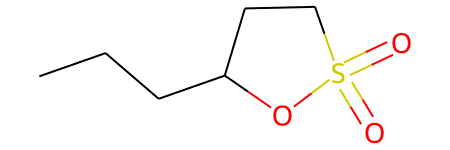

In [69]:
from rdkit import Chem
Chem.MolFromSmiles('O=S1(=O)CCC(CCC)O1')

In [70]:
#txp_msti_enriched.to_csv(interim_dir+'enriched_msti_p2_190822.csv')

In [71]:
txp_msti_enriched.to_csv(interim_dir+'enriched_msti_p2_240123.csv')

In [72]:
orig_enriched = pd.read_csv(interim_dir+'enriched_msti_p2_190822.csv')

In [73]:
len(set(orig_enriched.TxP.tolist()).intersection(set(txp_msti_enriched.TxP.tolist())))

61

In [74]:
[e for e in orig_enriched.TxP.tolist() if e not in txp_msti_enriched.TxP.tolist()]

[]

Change in 'greater than' in the Fisher exact test made no difference in the enriched TxPs identified.

Per reviewer's suggestion - the manner in which we identify 'enriched' TxPs may suffer from the multiple comparisons problem since we are using multiple univariate tests. There are several approaches to correct for the multiple comparison problem to ensure that the Family wise error rate (FWER) is reasonable. Of these the Bonferroni correction is probably the simplest and most conservative approach. Others include Sidak, Holm-Sidaj, FDR etc. 

The Bonferroni correction is attempted by a manual approach. This and the other approaches are evaluated using the multipletests function already implemented in the statsmodels library.

In [75]:
def bonferroni_correction_function(alpha, no_test):
    alpha_bonferroni = alpha/no_test
    return alpha_bonferroni

In [76]:
txp_msti_enrich.shape

(611, 8)

Based on the number of Fisher tests performed - we would need to adjust the alpha for the 611 tests performed.

In [77]:
bc = bonferroni_correction_function(0.05,611)
bc

8.183306055646482e-05

Based on the Bonferroni correction the FWER would be ~5%.

In [78]:
1-(1-bc)**611

0.048772521653823064

In [79]:
mylst = []
for x,y in zip(txp_msti_enrich['TxP'], txp_msti_enrich['p']):
    if y < bc:
        mylst.append([x, y ])

In [80]:
len(mylst)

71

Based on the Bonferroni correct of all the posssible tests - then the number of enriched TxPs would result would be 71

In [82]:
from venn import venn


Venn diagram to compare the TxPs that would have been identified as significant based on uncorrected p values vs those identified based on the Bonferroni correction and those TxPs originally identified as enriched based on an non corrected p value, the OR and TP considerations. 

In [83]:
mydict2 = {'bonferroni_TxPs':set(pd.DataFrame(mylst)[0].tolist()), 'original_TxPs': set(txp_msti_enriched.TxP.tolist()), 'uncorrected_TxPs' : set(txp_msti_enrich[(txp_msti_enrich['p'] < 0.05 ) ]['TxP'].tolist()) }

<AxesSubplot:>

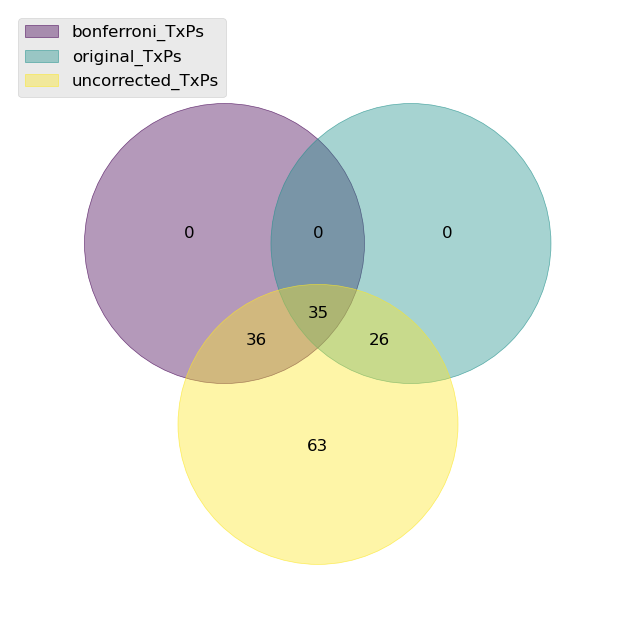

In [84]:
plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(18, 8))
#plt.figure(figsize=(18, 8))
venn(mydict2, cmap="viridis", fontsize=12, legend_loc="upper left",ax = ax )

Far more TxPs are identified as significant based on the uncorrected p value but factoring TPs and ORs results in a reasonable number of enriched TxPs commensurate in number with those identified based on the Bonferroni correction. If the addition TPs and OR criteria are factored that of the 71 TxPs first identified only 35 remain. 

Trying different correction options using the statsmodels library for convenience

In [89]:
from statsmodels.stats.multitest import multipletests

In [90]:
y = multipletests(pvals=txp_msti_enrich.p.values, alpha=0.05, method="b")

In [91]:
print(len(y[1][np.where(y[1]<0.05)])) 

71


In [92]:
#y[1]

In [93]:
txp_msti_enrich['Bonferroni_p'] = y[1]

In [94]:
txp_msti_enrich

,OR,p,TxP,TP,FN,FP,TN,Tested_Active,Bonferroni_p
188,inf,0.007068,bond:N=N_azo_aliphatic_acyclic,4,2181,0,5347,2185,1.0
14,inf,0.024389,bond:C(~Z)~C~Q_a-haloketone_perhalo,3,2182,0,5347,2185,1.0
17,inf,0.024389,bond:C(~Z)~C~Q_halocarbonyl_dichloro_quinone_(...,3,2182,0,5347,2185,1.0
37,inf,0.024389,bond:C(=O)O_carboxylicEster_4-nitrophenol,3,2182,0,5347,2185,1.0
201,inf,0.024389,bond:NN_hydrazine_alkyl_H,3,2182,0,5347,2185,1.0
...,...,...,...,...,...,...,...,...,...
603,0.0,1.000000,ring:polycycle_bicyclo_[3.2.2]nonane,0,2185,2,5345,2185,1.0
605,0.0,1.000000,ring:polycycle_bicyclo_[3.3.2]decane,0,2185,2,5345,2185,1.0
607,0.0,1.000000,ring:polycycle_spiro_[2.5]octane,0,2185,1,5346,2185,1.0
608,0.0,1.000000,ring:polycycle_spiro_[4.5]decane,0,2185,3,5344,2185,1.0


In [95]:
 txp_msti_enrich[(txp_msti_enrich['OR'] >= 3) & (txp_msti_enrich['Bonferroni_p'] < 0.05 ) & (txp_msti_enrich['TP'] >=3)]

,OR,p,TxP,TP,FN,FP,TN,Tested_Active,Bonferroni_p
82,31.997238,1.029204e-06,bond:CN_amine_aromatic_benzidine,13,2172,1,5346,2185,6.288435e-04
525,29.522319,3.314088e-06,ring:hetero_[5]_O_furan_a-nitro,12,2173,1,5346,2185,2.024908e-03
506,21.447806,1.916883e-18,ring:hetero_[4]_N_beta_lactam,43,2142,5,5342,2185,1.171216e-15
505,17.869826,1.128051e-17,ring:hetero_[4]_N_azetidine,43,2142,6,5341,2185,6.892393e-15
508,14.033586,3.032603e-17,ring:hetero_[4]_Z_generic,45,2140,8,5339,2185,1.852921e-14
71,11.717105,1.432523e-07,bond:CC(=O)C_ketone_alkene_cyclic_3-en-1-one,19,2166,4,5343,2185,8.752713e-05
76,11.477419,1.806702e-16,bond:CC(=O)C_quinone_1_4-benzo,46,2139,10,5337,2185,1.103895e-13
189,10.497542,2.150069e-13,bond:N=N_azo_aromatic,38,2147,9,5338,2185,1.313692e-10
77,8.940530,5.665562e-12,bond:CC(=O)C_quinone_1_4-naphtho,36,2149,10,5337,2185,3.461658e-09
590,8.638401,2.082597e-07,ring:hetero_[6_6_6]_N_S_phenothiazine,21,2164,6,5341,2185,1.272467e-04


Based on 3 criteria - of the 71 TxPs, 35 remain. These could be carried forward to the remainder of the analysis, however this would be the most conservative means of identifying enriched TxPs.

Sidak correction

In [96]:
y1 = multipletests(pvals=txp_msti_enrich.p.values, alpha=0.05, method="sidak")

/home/grace/anaconda3/envs/aim_clone/lib/python3.8/site-packages/statsmodels/stats/multitest.py:155: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


In [97]:
print(len(y1[1][np.where(y1[1]<0.05)])) 

71


In [98]:
txp_msti_enrich['Sidak_p'] = y1[1]

Benjamini and Hochberg controls for FDR

In [99]:
y2=multipletests(pvals=txp_msti_enrich.p.values, alpha=0.05, method="fdr_bh")

In [100]:
print(len(y2[1][np.where(y2[1]<0.05)])) 

119


In [101]:
txp_msti_enrich['FDR_p'] = y2[1]

In [102]:
#txp_msti_enrich[txp_msti_enrich['Bonferroni_p'] <0.05]['TxP'].tolist()

In [103]:
mydict3 = {'bonferroni_TxPs':set(txp_msti_enrich[txp_msti_enrich['Bonferroni_p'] <0.05]['TxP'].tolist()),
           'Sidak_TxPs': set(txp_msti_enrich[txp_msti_enrich['Sidak_p'] <0.05]['TxP'].tolist()),
           'FDR_TxPs': set(txp_msti_enrich[txp_msti_enrich['FDR_p'] <0.05]['TxP'].tolist())}

<AxesSubplot:>

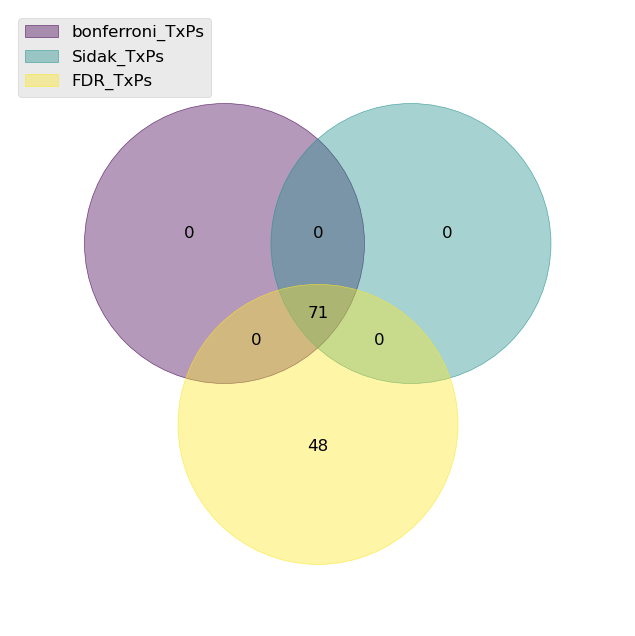

In [104]:
plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(18, 8))
#plt.figure(figsize=(18, 8))
venn(mydict3, cmap="viridis", fontsize=12, legend_loc="upper left",ax = ax )

In [107]:
txp_msti_enrich[(txp_msti_enrich['OR'] >= 3) & (txp_msti_enrich['FDR_p'] < 0.05 ) & (txp_msti_enrich['TP'] >=3)].shape

(47, 11)

In [109]:
txp_msti_enrich[(txp_msti_enrich['OR'] >= 3)  & (txp_msti_enrich['TP'] >=3)].to_csv(interim_dir+'enrich_TxPs_250123.csv')

Apply all 3 considerations to limit number of enriched TxPs

In [164]:
txp_msti_enrich[(txp_msti_enrich['OR'] >= 3) & (txp_msti_enrich['FDR_p'] < 0.05 ) & (txp_msti_enrich['TP'] >=3)].sort_values(by = ['OR', 'TP', 'FDR_p'], ascending = [False, False, True]).to_csv(interim_dir+'enriched_TxPs_250123.csv')

In [165]:
txp_msti_enrich[(txp_msti_enrich['OR'] >= 3) & (txp_msti_enrich['FDR_p'] < 0.05 ) & (txp_msti_enrich['TP'] >=3)].head()

,OR,p,TxP,TP,FN,FP,TN,Tested_Active,Bonferroni_p,Sidak_p,FDR_p
188,inf,7.068338e-03,bond:N=N_azo_aliphatic_acyclic,4,2181,0,5347,2185,1.000000e+00,9.868862e-01,3.890770e-02
82,31.997238,1.029204e-06,bond:CN_amine_aromatic_benzidine,13,2172,1,5346,2185,6.288435e-04,6.286462e-04,1.164525e-05
525,29.522319,3.314088e-06,ring:hetero_[5]_O_furan_a-nitro,12,2173,1,5346,2185,2.024908e-03,2.022863e-03,3.491221e-05
506,21.447806,1.916883e-18,ring:hetero_[4]_N_beta_lactam,43,2142,5,5342,2185,1.171216e-15,1.171216e-15,9.009352e-17
505,17.869826,1.128051e-17,ring:hetero_[4]_N_azetidine,43,2142,6,5341,2185,6.892393e-15,6.892393e-15,4.923138e-16


Inspection of specific ToxPrints to explore potential inferences of relevance to reactivity potential

In [178]:
tox21_smi = pd.read_excel(external_dir+'DSSTox_TOX21SL_20220408.xlsx')

In [187]:
from rdkit.Chem.Draw import MolsToGridImage

In [191]:
tox21_smi[tox21_smi['DSSTox_Substance_Id'].isin(df2[df2['bond:N=N_azo_aliphatic_acyclic'] ==1].index)]['Structure_SMILES_2D-QSAR'].tolist()[0]

'OC(=O)C1=NN(C(=O)C1N=NC1=CC=C(C=C1)S(O)(=O)=O)C1=CC=C(C=C1)S(O)(=O)=O'

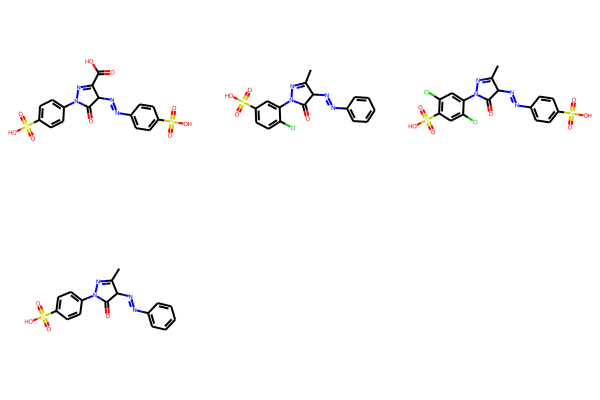

In [188]:
MolsToGridImage([Chem.MolFromSmiles(e) for e in tox21_smi[tox21_smi['DSSTox_Substance_Id'].isin(df2[df2['bond:N=N_azo_aliphatic_acyclic'] ==1].index)]['Structure_SMILES_2D-QSAR']])

Figure 5

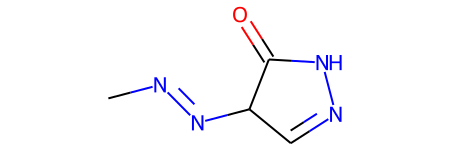

In [195]:
Chem.MolFromSmiles('C1=NNC(=O)C1N=NC')

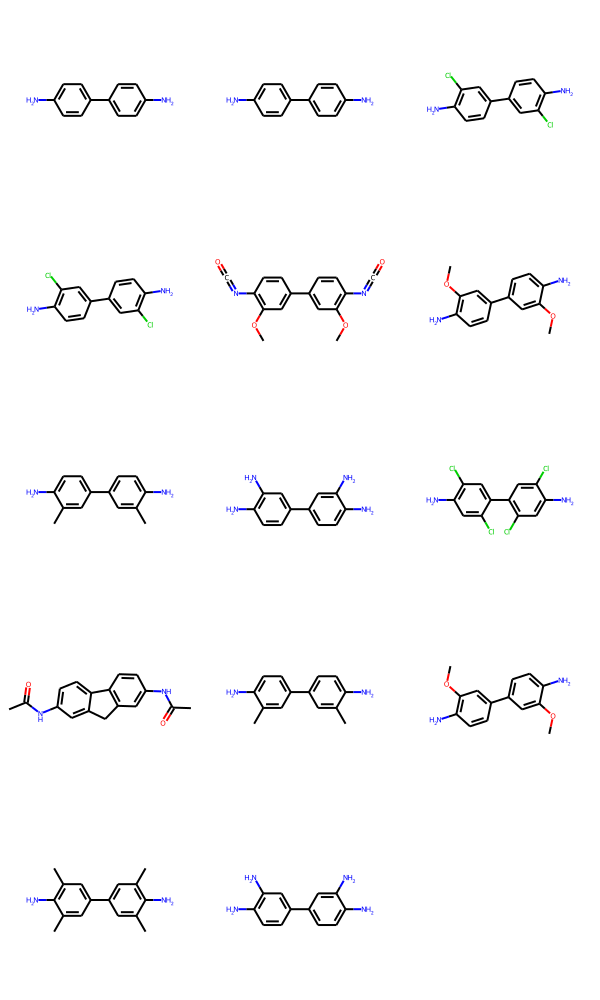

In [204]:
MolsToGridImage([Chem.MolFromSmiles(e) for e in tox21_smi[tox21_smi['DSSTox_Substance_Id'].isin(df2[df2['bond:CN_amine_aromatic_benzidine'] ==1].index)]['Structure_SMILES_2D-QSAR']])

In [209]:
def figure_mols(dft, dfs, Txp='bond:N=N_azo_aliphatic_acyclic'):
    return MolsToGridImage([Chem.MolFromSmiles(e) for e in dfs[dfs['DSSTox_Substance_Id'].isin(dft[dft[Txp] ==1].index)]['Structure_SMILES_2D-QSAR']])

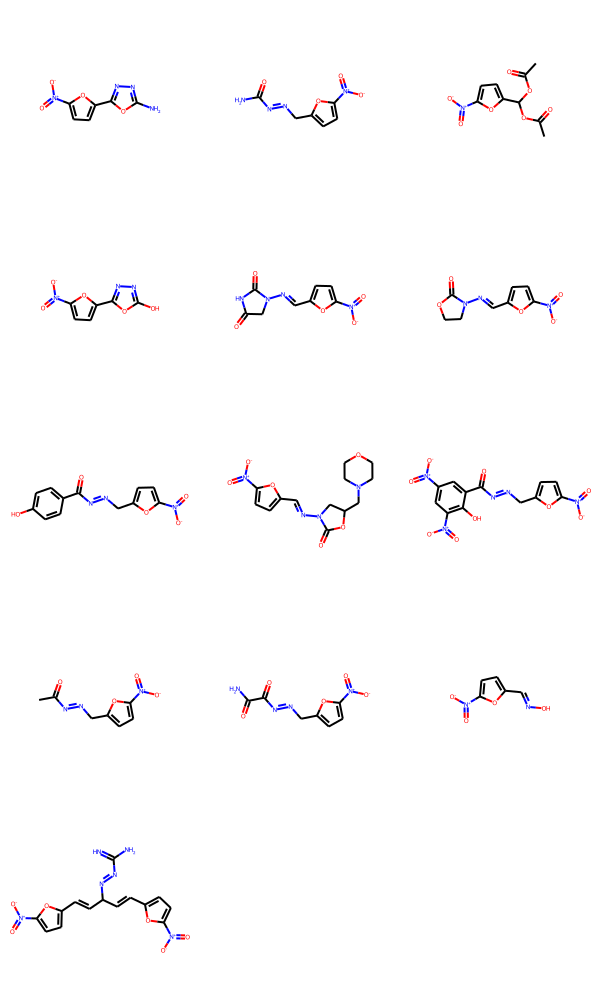

In [212]:
figure_mols(df2, tox21_smi, Txp = 'ring:hetero_[5]_O_furan_a-nitro')

In [222]:
def figure_mols(dft, dfs, Txp='bond:N=N_azo_aliphatic_acyclic'):
    return MolsToGridImage([Chem.MolFromSmiles(e) for e in dfs[dfs['DSSTox_Substance_Id'].isin(dft[dft[Txp] ==1].index)]['Structure_SMILES_2D-QSAR'].dropna()])

In [228]:
tox21_smi[tox21_smi['DSSTox_Substance_Id'].isin(df2[df2['ring:hetero_[4]_N_azetidine'] ==1].index)].head()

,DSSTox_Source_Record_Id,Extenal_ID,DSSTox_Substance_Id,DSSTox_Structure_Id,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,Structure_SMILES,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,Structure_SMILES_2D-QSAR,DateModified
37,DTXRID6075354,NaN,DTXSID9020083,DTXCID4083,DSSTox_High,Ampicillin trihydrate,7177-48-2,Single Compound,NaN,O.O.O.[H][C@]12SC(C)(C)[C@@H](N1C(=O)[C@H]2NC(...,InChI=1S/C16H19N3O4S.3H2O/c1-16(2)11(15(22)23)...,RXDALBZNGVATNY-CWLIKTDRSA-N,C16H25N3O7S,403.450,CC1(C)SC2C(NC(=O)C(N)C3=CC=CC=C3)C(=O)N2C1C(O)=O,20220114
65,DTXRID8075382,NaN,DTXSID3020120,DTXCID50120,DSSTox_High,Azelnidipine,123524-52-7,Single Compound,NaN,CC(C)OC(=O)C1=C(C)NC(N)=C(C1C1=CC(=CC=C1)[N+](...,InChI=1/C33H34N4O6/c1-20(2)42-32(38)27-21(3)35...,ZKFQEACEUNWPMT-UHFFFAOYNA-N,C33H34N4O6,582.657,CC(C)OC(=O)C1C(C2=CC(=CC=C2)[N+]([O-])=O)C(C(=...,20210719
623,DTXRID5075941,NaN,DTXSID7021102,DTXCID101102,DSSTox_Low,Penicillin VK,132-98-9,Single Compound,NaN,[K+].CC1(C)S[C@@H]2[C@H](NC(=O)COC3=CC=CC=C3)C...,InChI=1S/C16H18N2O5S.K/c1-16(2)12(15(21)22)18-...,HCTVWSOKIJULET-LQDWTQKMSA-M,C16H17KN2O5S,388.480,CC1(C)SC2C(NC(=O)COC3=CC=CC=C3)C(=O)N2C1C(O)=O,20171019
1325,DTXRID8076643,NaN,DTXSID3022584,DTXCID901511053,DSSTox_High,Amdinocillin,32887-01-7,Mixture of Stereoisomers,NaN,CC1(C)S[C@@H]2[C@H](N=CN3CCCCCC3)C(=O)N2[C@H]1...,InChI=1S/C15H23N3O3S/c1-15(2)11(14(20)21)18-12...,BWWVAEOLVKTZFQ-NTZNESFSSA-N,C15H23N3O3S,325.430,NaN,20210719
1336,DTXRID7076654,NaN,DTXSID4022602,DTXCID202602,DSSTox_High,Ampicillin,69-53-4,Single Compound,NaN,[H][C@]12SC(C)(C)[C@@H](N1C(=O)[C@H]2NC(=O)[C@...,InChI=1S/C16H19N3O4S/c1-16(2)11(15(22)23)19-13...,AVKUERGKIZMTKX-NJBDSQKTSA-N,C16H19N3O4S,349.410,CC1(C)SC2C(NC(=O)C(N)C3=CC=CC=C3)C(=O)N2C1C(O)=O,20220114


In [232]:
#figure_mols(df2, tox21_smi, Txp = 'ring:hetero_[4]_N_azetidine')

In [233]:
#figure_mols(df2, tox21_smi, Txp = 'ring:hetero_[6_6_6]_N_S_phenothiazine')

In [234]:
tox21_smi[tox21_smi['DSSTox_Substance_Id'].isin(df2[df2['ring:hetero_[6_6_6]_N_S_phenothiazine'] ==1].index)].head()

,DSSTox_Source_Record_Id,Extenal_ID,DSSTox_Substance_Id,DSSTox_Structure_Id,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,Structure_SMILES,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,Structure_SMILES_2D-QSAR,DateModified
639,DTXRID9075957,NaN,DTXSID5021126,DTXCID301126,DSSTox_High,Phenothiazine,92-84-2,Single Compound,NaN,N1C2=CC=CC=C2SC2=C1C=CC=C2,InChI=1S/C12H9NS/c1-3-7-11-9(5-1)13-10-6-2-4-8...,WJFKNYWRSNBZNX-UHFFFAOYSA-N,C12H9NS,199.27,N1C2=CC=CC=C2SC2=C1C=CC=C2,20210719
684,DTXRID9076002,NaN,DTXSID3021192,DTXCID801192,DSSTox_High,Promethazine hydrochloride,58-33-3,Mixture of Stereoisomers,NaN,Cl.CC(CN1C2=CC=CC=C2SC2=C1C=CC=C2)N(C)C,InChI=1/C17H20N2S.ClH/c1-13(18(2)3)12-19-14-8-...,XXPDBLUZJRXNNZ-UHFFFAOYNA-N,C17H21ClN2S,320.88,CC(CN1C2=C(SC3=C1C=CC=C3)C=CC=C2)N(C)C,20210719
1418,DTXRID2076736,NaN,DTXSID0022808,DTXCID002808,DSSTox_High,Chlorpromazine,50-53-3,Single Compound,NaN,CN(C)CCCN1C2=C(SC3=C1C=C(Cl)C=C3)C=CC=C2,InChI=1S/C17H19ClN2S/c1-19(2)10-5-11-20-14-6-3...,ZPEIMTDSQAKGNT-UHFFFAOYSA-N,C17H19ClN2S,318.86,CN(C)CCCN1C2=C(SC3=C1C=C(Cl)C=C3)C=CC=C2,20210719
1544,DTXRID7076862,NaN,DTXSID2023068,DTXCID303068,DSSTox_High,Fluphenazine,69-23-8,Single Compound,NaN,OCCN1CCN(CCCN2C3=CC=CC=C3SC3=CC=C(C=C23)C(F)(F...,"InChI=1S/C22H26F3N3OS/c23-22(24,25)17-6-7-21-1...",PLDUPXSUYLZYBN-UHFFFAOYSA-N,C22H26F3N3OS,437.53,OCCN1CCN(CCCN2C3=CC=CC=C3SC3=CC=C(C=C23)C(F)(F...,20171127
1629,DTXRID7076947,NaN,DTXSID8023262,DTXCID303262,DSSTox_High,Mequitazine,29216-28-2,Single Compound,NaN,C(C1CN2CCC1CC2)N1C2=CC=CC=C2SC2=C1C=CC=C2,InChI=1/C20H22N2S/c1-3-7-19-17(5-1)22(18-6-2-4...,HOKDBMAJZXIPGC-UHFFFAOYNA-N,C20H22N2S,322.47,C(C1CN2CCC1CC2)N1C2=CC=CC=C2SC2=C1C=CC=C2,20210719


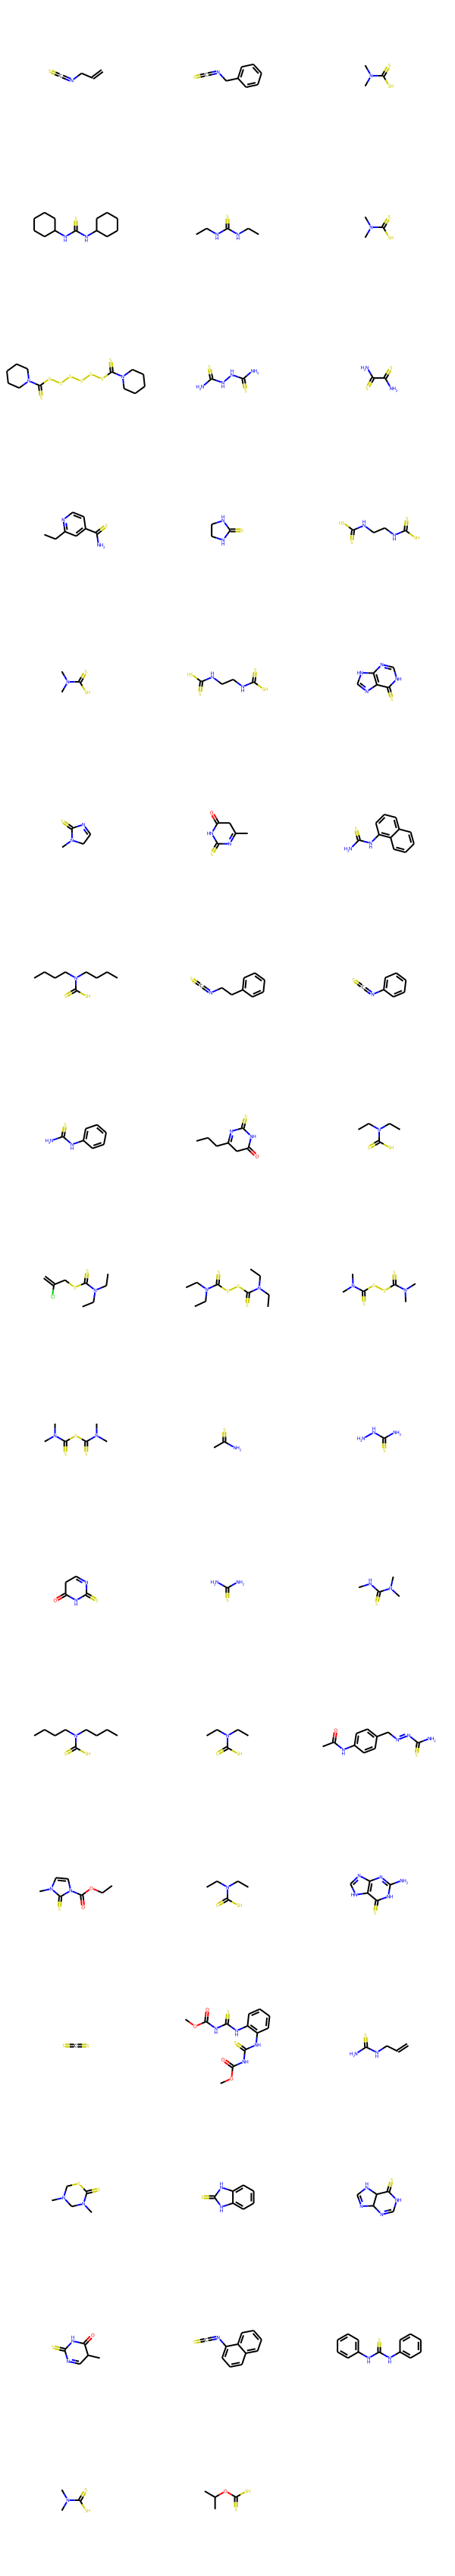

In [239]:
figure_mols(df2, tox21_smi, Txp = 'bond:C=S_carbonyl_thio_generic')

Sanity check on what TxPs should be considered relative to their distribution in the inventory. <br>
Reading in the ToxPrints in a Level 2 condense format for profiling purposes (not included in the manuscript)

In [110]:
txpts = pd.read_csv(external_dir+'toxprint_V2.0_r711_5Levels.csv')

In [111]:
level2_dict = {}
for x,y in txpts.groupby(['Level 2 full']):
    k = [e for e in y['Level 2 full'] if e!= ' '][0]
    v = set(y['ToxPrint_chemotype_name (original)'])
    level2_dict[k]=v

In [140]:
len(level2_dict.keys())

70

In [115]:
df3 = df2.iloc[:,:-3]

In [119]:
df3 = df3.reset_index()

In [120]:
def prep_df(df, ID = 'M_NAME'):
    df2 = df.copy()
    df3 = pd.melt(df2,id_vars= ID, value_vars = df2.columns[1:])
    df3 = df3.replace(0, np.nan)
    df3.dropna(axis = 0, how = 'any', inplace = True)
    df3.rename(columns={'variable': 'toxprint'}, inplace=True)
    return df3

In [122]:
msti_tps_long = prep_df(df3, ID = 'dsstox_substance_id')
msti_tps_long

,dsstox_substance_id,toxprint,value
4537,DTXSID8020121,atom:element_main_group,1.0
7781,DTXSID8045228,atom:element_metal_group_I_II,1.0
7783,DTXSID7041126,atom:element_metal_group_I_II,1.0
8106,DTXSID4045551,atom:element_metal_group_I_II,1.0
8107,DTXSID9023386,atom:element_metal_group_I_II,1.0
...,...,...,...
5475796,DTXSID8022117,ring:polycycle_tricyclo_adamantane,1.0
5475917,DTXSID5045174,ring:polycycle_tricyclo_adamantane,1.0
5476947,DTXSID1047813,ring:polycycle_tricyclo_adamantane,1.0
5477253,DTXSID5046481,ring:polycycle_tricyclo_adamantane,1.0


In [123]:
tag = {e:k for e in msti_tps_long['toxprint'] for k,v in level2_dict.items() if e in v}

In [124]:
msti_tps_long['aggregate_toxprint'] = msti_tps_long['toxprint'].replace(tag)

In [126]:

msti_bar = msti_tps_long.aggregate_toxprint.value_counts().reset_index()
msti_bar.rename(columns = {'index' : 'Txp', 'aggregate_toxprint' : 'count'}, inplace = True)
msti_bar.head()

,Txp,count
0,ring:hetero,12030
1,chain:alkaneLinear,9184
2,bond:CN_amine,8122
3,chain:aromaticAlkane,7114
4,bond:COH_alcohol,6237


In [146]:
[e for e in msti_bar.Txp if  e  not in level2_dict.keys()]

['bond:P=O_phosphonate_thio_dimethyl_methylphosphonothionate']

In [155]:
msti_bar[msti_bar['count']  < 5]

,Txp,count
63,bond:Se~Q,4
64,chain:oxy-alkaneBranch,4
65,bond:N=[N+]=[N-]_azide,4
66,bond:quatS,3
67,bond:P=O_phosphonate_thio_dimethyl_methylphosp...,2
68,atom:element_main_group,1


In [137]:
#msti_bar.hist()

<AxesSubplot:>

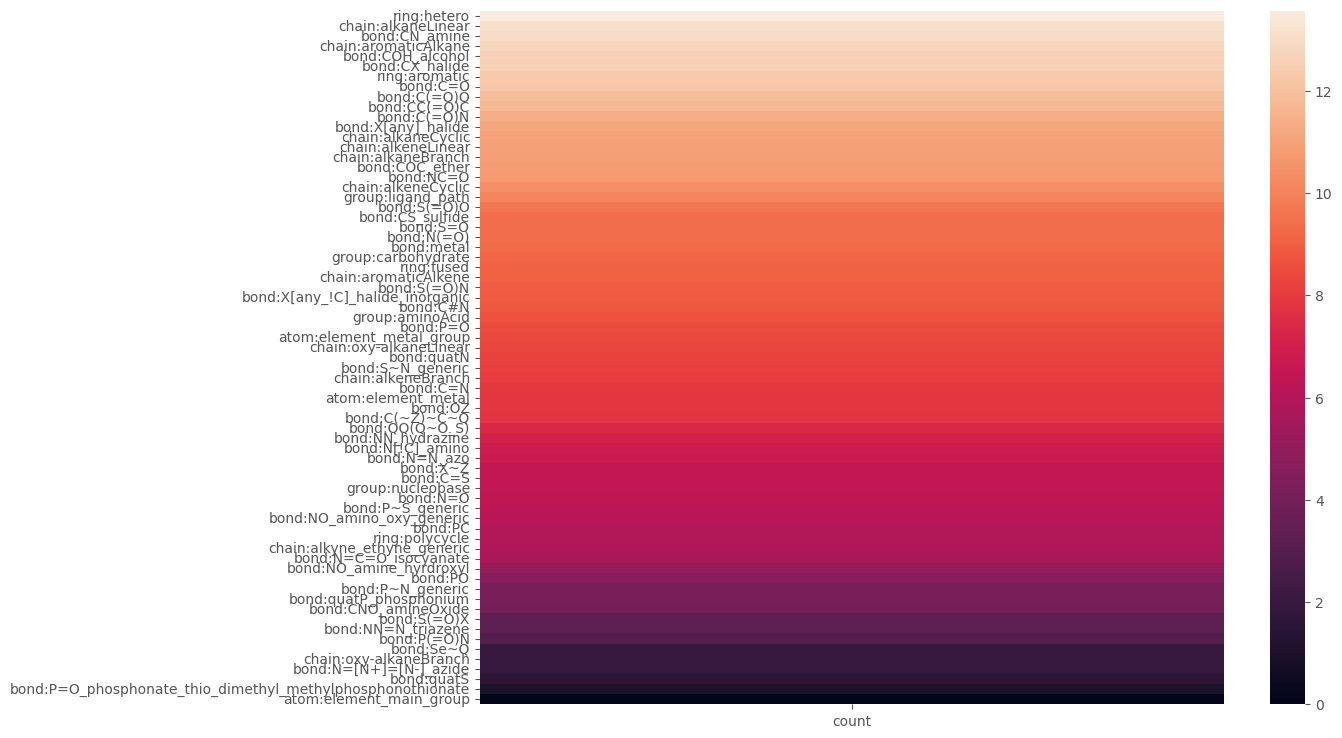

In [156]:
plt.figure(figsize = (12,9))
sns.heatmap(np.log2(msti_bar.iloc[:,1:]), yticklabels= msti_bar.iloc[:,0])

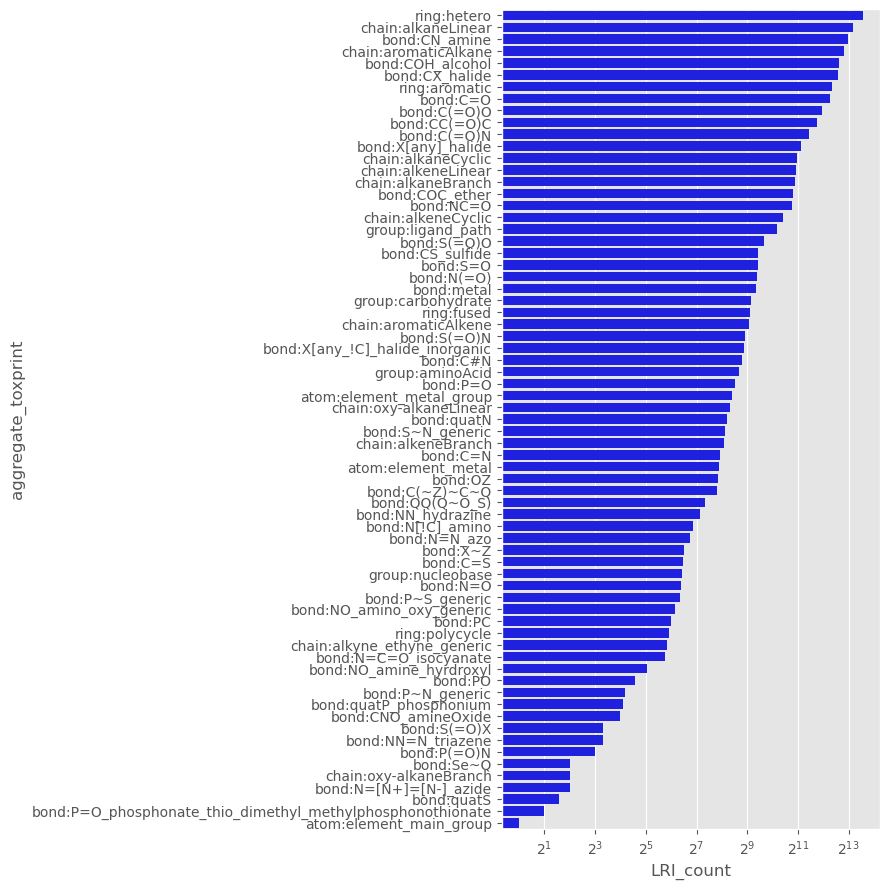

In [157]:
f,ax = plt.subplots(figsize=(9,9))


sns.barplot(x = 'count', y = 'Txp', color = 'blue',label = "msti", data = msti_bar, ax=ax)


ax.set_ylabel('aggregate_toxprint')


ax.set_xlabel('LRI_count')
ax.set_xscale('log', base=2)

plt.tight_layout()

#f.savefig(figures_dir+'toxprints_comparison_290322.png', dpi = 300)

There are 70 profiling TxPs, Tox21 library has coverage across 69 of these. 

#### Comparisons with the Nelms et al (2019) profiled Tox21SL 

In [66]:
rxn_tox21 = pd.read_excel(external_dir+'tox21_rxn.xlsx', sheet_name = 'tox_rxn')

In [67]:
rxn_tox21

,Unnamed: 0,DTXSID,Dow_domain,DTXSID.1,Enoch_domain,DTXSID.2,OECD,Enoch,Dow,OECD_domain,Consensus_mech,rxn_domains
0,0,DTXSID0020020,[],DTXSID0020020,['Acyl'],DTXSID0020020,['Acyl'],['Acyl'],[],['Acyl'],['Acyl'],Acyl
1,1,DTXSID0020022,[],DTXSID0020022,[],DTXSID0020022,[],[],[],[],[],no_domain
2,2,DTXSID0020024,[],DTXSID0020024,[],DTXSID0020024,[],[],[],[],[],no_domain
3,3,DTXSID0020070,[],DTXSID0020070,['SB'],DTXSID0020070,['SB'],['SB'],[],['SB'],['SB'],SB
4,4,DTXSID0020072,[],DTXSID0020072,[],DTXSID0020072,[],[],[],[],[],no_domain
...,...,...,...,...,...,...,...,...,...,...,...,...
8349,8349,DTXSID9057844,[],DTXSID9057844,"['Acyl', 'SN2']",DTXSID9057844,['SN2'],"['Acyl', 'SN2']",[],['SN2'],['inconclusive'],inconclusive
8350,8350,DTXSID9057846,[],DTXSID9057846,[],DTXSID9057846,['MA'],[],[],['MA'],[],no_domain
8351,8351,DTXSID9057848,[],DTXSID9057848,[],DTXSID9057848,[],[],[],[],[],no_domain
8352,8352,DTXSID9057898,['SN2'],DTXSID9057898,[],DTXSID9057898,['SN2'],[],['SN2'],['SN2'],['SN2'],SN2


In [68]:
rxn_tox21 = rxn_tox21[['DTXSID', 'Enoch', 'Dow', 'OECD','rxn_domains']]

Designate a positive for anything with a reaction domain assignment

In [69]:
rxn_tox21['rxn_hitc'] = rxn_tox21['rxn_domains'].apply(lambda x: 0 if x == 'no_domain' else 1)

<ipython-input-69-1a9fcd56cb2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rxn_tox21['rxn_hitc'] = rxn_tox21['rxn_domains'].apply(lambda x: 0 if x == 'no_domain' else 1)


In [70]:
rxn_tox21.rxn_hitc.value_counts(normalize = True)

0    0.552909
1    0.447091
Name: rxn_hitc, dtype: float64

In [71]:
rxn_tox21

,DTXSID,Enoch,Dow,OECD,rxn_domains,rxn_hitc
0,DTXSID0020020,['Acyl'],[],['Acyl'],Acyl,1
1,DTXSID0020022,[],[],[],no_domain,0
2,DTXSID0020024,[],[],[],no_domain,0
3,DTXSID0020070,['SB'],[],['SB'],SB,1
4,DTXSID0020072,[],[],[],no_domain,0
...,...,...,...,...,...,...
8349,DTXSID9057844,"['Acyl', 'SN2']",[],['SN2'],inconclusive,1
8350,DTXSID9057846,[],[],['MA'],no_domain,0
8351,DTXSID9057848,[],[],[],no_domain,0
8352,DTXSID9057898,[],['SN2'],['SN2'],SN2,1


In [72]:
df2 = df.set_index('dsstox_substance_id')

In [73]:
rxn_tox21 = rxn_tox21.set_index('DTXSID')

Although we have value counts - to compare relative between the 2 datasets - look at a common index

In [74]:
rxn_tox21.index.intersection(df2.index)

Index(['DTXSID0020020', 'DTXSID0020022', 'DTXSID0020024', 'DTXSID0020070',
       'DTXSID0020072', 'DTXSID0020074', 'DTXSID0020076', 'DTXSID0020105',
       'DTXSID0020107', 'DTXSID0020151',
       ...
       'DTXSID9057765', 'DTXSID9057767', 'DTXSID9057769', 'DTXSID9057840',
       'DTXSID9057842', 'DTXSID9057844', 'DTXSID9057846', 'DTXSID9057848',
       'DTXSID9057898', 'DTXSID9058654'],
      dtype='object', length=7363)

In [75]:
rxn_tox21_ = rxn_tox21.loc[rxn_tox21.index.intersection(df2.index), :]

In [76]:
rxn_tox21_

,Enoch,Dow,OECD,rxn_domains,rxn_hitc
DTXSID0020020,['Acyl'],[],['Acyl'],Acyl,1
DTXSID0020022,[],[],[],no_domain,0
DTXSID0020024,[],[],[],no_domain,0
DTXSID0020070,['SB'],[],['SB'],SB,1
DTXSID0020072,[],[],[],no_domain,0
...,...,...,...,...,...
DTXSID9057844,"['Acyl', 'SN2']",[],['SN2'],inconclusive,1
DTXSID9057846,[],[],['MA'],no_domain,0
DTXSID9057848,[],[],[],no_domain,0
DTXSID9057898,[],['SN2'],['SN2'],SN2,1


In [77]:
df2_ = df2.loc[rxn_tox21.index.intersection(df2.index), :]

In [78]:
df2_

,chnm,casn,hitc
DTXSID0020020,4-Acetylaminophenylacetic acid,18699-02-0,0
DTXSID0020022,Acifluorfen,50594-66-6,1
DTXSID0020024,Acrolein diethylacetal,3054-95-3,0
DTXSID0020070,Aminocaproic acid,60-32-2,0
DTXSID0020072,4-Biphenylamine hydrochloride,2113-61-3,1
...,...,...,...
DTXSID9057844,Indomethacin farnesil,85801-02-1,1
DTXSID9057846,Fluoroquinolonic acid,86393-33-1,1
DTXSID9057848,Setoperone,86487-64-1,0
DTXSID9057898,2-Amino-4-(trifluoromethyl)benzenethiol hydroc...,4274-38-8,0


In [79]:
from sklearn.metrics import confusion_matrix, classification_report,precision_recall_curve

Construct a confusion matrix, nominally using the MSTI data as 'truth' and calculate metrics such as precision and recall

In [80]:
pd.crosstab(df2_['hitc'], rxn_tox21_['rxn_hitc'])

rxn_hitc,0,1
hitc,,
0,3057,2168
1,1061,1077


In [81]:
confusion_matrix(df2_['hitc'], rxn_tox21_['rxn_hitc'], labels=[1,0])

array([[1077, 1061],
       [2168, 3057]])

In [82]:
tn, fp, fn, tp = confusion_matrix(df2_['hitc'], rxn_tox21_['rxn_hitc']).ravel()
tn, fp, fn, tp

(3057, 2168, 1061, 1077)

In [83]:
print(classification_report(df2_['hitc'], rxn_tox21_['rxn_hitc'], labels = [1,0]))

              precision    recall  f1-score   support

           1       0.33      0.50      0.40      2138
           0       0.74      0.59      0.65      5225

    accuracy                           0.56      7363
   macro avg       0.54      0.54      0.53      7363
weighted avg       0.62      0.56      0.58      7363



precision

In [84]:
tp/(tp+fp)

0.33189522342064715

recall (sensitivity)

In [85]:
tp/(tp+fn)

0.5037418147801683

specificity

In [91]:
tn/(tn+fp)

0.5850717703349282

However perhaps the MSTI only picks up soft electrophiles in which as rxn domains that are SB and Acyl are both more likely to be lysine active

In [92]:
rxn_filtered = rxn_tox21_[rxn_tox21_['rxn_domains'].isin(['Acyl', 'no_domain', 'SB',  'SN2', 'MA', 'SNAR'])].copy()

In [93]:
rxn_filtered['soft'] = rxn_filtered[['rxn_domains', 'rxn_hitc']].apply(lambda x: 0 if x['rxn_domains'] in ['Acyl', 'SB'] else x['rxn_hitc'], axis =1)

In [94]:
rxn_filtered.soft.value_counts(normalize = True)

0    0.805941
1    0.194059
Name: soft, dtype: float64

In [95]:
rxn_filtered.shape

(6766, 6)

In [96]:
df3 = df2_.loc[df2_.index.intersection(rxn_filtered.index),:]

In [97]:
df3.hitc.value_counts(normalize = True)

0    0.716376
1    0.283624
Name: hitc, dtype: float64

In [98]:
rxn_filtered.soft.value_counts(normalize = True)

0    0.805941
1    0.194059
Name: soft, dtype: float64

In [99]:
print(classification_report(df3['hitc'], rxn_filtered['soft'], labels = [1,0]))

              precision    recall  f1-score   support

           1       0.35      0.24      0.28      1919
           0       0.73      0.82      0.78      4847

    accuracy                           0.66      6766
   macro avg       0.54      0.53      0.53      6766
weighted avg       0.62      0.66      0.64      6766



In [100]:
pd.crosstab(df3['hitc'], rxn_filtered['soft'])

soft,0,1
hitc,,
0,3994,853
1,1459,460
